In [1]:
import textgrid
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import scipy
import librosa
import re
import glob
import scipy
import sys
sys.path.append(r"C:\Users\Ambre\Documents\Boulot\stage_m2")
from trf import *
plt.style.use('seaborn-v0_8')

In [2]:
FONT_SIZE= 12
plt.rcParams.update({
    # 'figure.dpi': 150,
    # 'savefig.dpi': 300,
    # 'savefig.transparent': True,
    # # Font
    # 'font.family': 'sans-serif',
    # 'font.sans-serif': FONT,
    'font.size': FONT_SIZE,
    'axes.labelsize': FONT_SIZE,
    'axes.titlesize': 14,
    'xtick.labelsize': FONT_SIZE,
    'ytick.labelsize': FONT_SIZE,
    'legend.fontsize': FONT_SIZE,
    # line width
    # 'axes.linewidth': LINEWIDTH,
    # 'grid.linewidth': LINEWIDTH,
    # 'lines.linewidth': LINEWIDTH,
    # 'patch.linewidth': LINEWIDTH,
    # 'xtick.major.width': LINEWIDTH,
    # 'xtick.minor.width': LINEWIDTH,
    # 'ytick.major.width': LINEWIDTH,
    # 'ytick.minor.width': LINEWIDTH,
})

In [3]:
#Lecture des fichiers d'annotation
def extract_phonemes(textgrid_file, audio_file, phonemes_to_exclude, sfreq):
    audio, orig_sfreq = librosa.load(audio_file)
    len_audio = librosa.get_duration(y = audio, sr = orig_sfreq)
    nb_sample_audio = len(librosa.resample(audio, orig_sr=orig_sfreq, target_sr=sfreq))
    print(nb_sample_audio)
    print(len_audio*sfreq, '\n')

    #we extract the data from the textgrid file
    tg = textgrid.TextGrid.fromFile(textgrid_file)
    phonemes = []
    phonemes_nb = []
    timings = []
    for interval in tg[0]: #the first tier is the one with the phonemes, we don't care about the other one (it contains the words)
        phoneme = interval.mark #get the text of the interval
        onset_sample = int(interval.minTime*sfreq)
        offset_sample = int(interval.maxTime*sfreq)
        phoneme = re.sub('\d', '', phoneme).strip() #there are digits after some phonemes, we remove them
        phonemes.append(phoneme)
        timings.append([onset_sample, offset_sample])
        if phoneme not in phonemes_nb:
            phonemes_nb.append(phoneme)

    phoneme_data = pd.DataFrame([phonemes, timings], index=['phoneme', 'timing']).T

    phoneme_arr_dic = {}
    for phoneme, timing in zip(phonemes, timings):
        if phoneme not in phonemes_to_exclude: #no column for silence, leaving all the colums blank is enough (?)
            empty_arr = np.zeros(int(nb_sample_audio))
            #range_to_ones = np.arange(timing[0], timing[1])

            #phoneme_arr = np.put(phoneme_arr, np.arange(timing[0], timing[1], step=1), v=1)
            if phoneme in phoneme_arr_dic.keys():
                phoneme_arr_dic[phoneme][timing[0]:timing[1]] =1
            else: 
                empty_arr[timing[0]:timing[1]]=1
                phoneme_arr_dic[phoneme]=empty_arr
        # else:
        #     if phoneme != 'sp':
                #print("phoneme", phoneme, "was excluded")

    #we sort the disctionnary by key so all trials will have their phonemes in the same order as in the study
    sorted_phoneme_dic = {}
    #OW and AO are absent from the paper and OY is in the paper but I removed it
    phonemes_order = ['sp', 'IY', 'UW', 'AE', 'AA', 'EH', 'ER', 'IH', 'UH', 'AH', 'EY', 'AY', 'AW', 'OW', 'AO', 'Y', 'L', 'R', 'W', 'B', 'D', 'F', 'HH', 'K', 'M', 'N', 'P', 'S', 'T', 'V', 'Z', 'DH', 'G', 'SH', 'CH', 'TH']
    for ordered_phoneme in phonemes_order:
        sorted_phoneme_dic[ordered_phoneme]=phoneme_arr_dic[ordered_phoneme]
    sorted_phoneme_dic = dict(sorted(phoneme_arr_dic.items()))
    regressor = np.stack([value.flatten() for value in sorted_phoneme_dic.values()], axis=0)
    # regressor = np.stack([value.flatten() for value in phoneme_arr_dic.values()], axis=0)
    time_df = pd.DataFrame([value.flatten() for value in sorted_phoneme_dic.values()], index=phoneme_arr_dic.keys())
    
    return regressor , time_df, phoneme_data, sorted_phoneme_dic

In [4]:
textgrid_path = r'..\Daube\hemingway\hemingway\CheckedTextGrids'
audio_path = r'..\Daube\hemingway\hemingway\Official'
audio_files = glob.glob(join(audio_path, '*.wav'))
textgrid_files = glob.glob(join(textgrid_path, '*.TextGrid'))
sorted_textgrids = sort_files(textgrid_files, 0)
sorted_audio = sort_files(audio_files, 0)


regressor_list = []
min_duration = 20071
df_list = []

for (k1, textgrid_file), (k2, audio_file), in zip(sorted_textgrids.items(), sorted_audio.items()):
    if k1<=20:
        regressor, time_df, phoneme_data, sorted_phoneme_dic =extract_phonemes(textgrid_file, audio_file, ['J', 'OH', 'ZH', 'A', 'JH', 'OY', ''], 100)
        df_list.append(pd.DataFrame(sorted_phoneme_dic).T)
        regressor_list.append(regressor.T)
        # regressor_list.append(regressor[:, :max_len].T)
        phoneme_count = phoneme_data.value_counts(subset ='phoneme').to_dict()
        
        #print(phoneme_count)
#[regressor.shape for regressor in regressor_list]
# = np.stack(regressor_list, axis = 1)

full_df = pd.concat(df_list, axis=1)

17757
17756.29931972789 

18070
18069.768707482992 

18008
18007.07482993197 

18135
18134.784580498865 

18033
18032.61678004535 

20213
20212.97052154195 

16573
16572.081632653062 

17109
17108.462585034013 

17594
17593.759637188206 

19296
19295.78231292517 

17557
17556.607709750566 

17977
17976.888888888887 

18321
18320.544217687075 

17843
17842.213151927437 

18335
18334.47619047619 

18611
18610.79365079365 

18748
18747.791383219952 

18117
18116.208616780044 

17743
17742.367346938776 

18906
18905.687074829933 



In [5]:
pd.DataFrame(sorted_phoneme_dic).T

,0,1,2,3,4,5,6,7,8,9,...,18896,18897,18898,18899,18900,18901,18902,18903,18904,18905
AA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
full_df.shape

(37, 362946)

In [7]:
model_path = "transformed_data_jp.pickle"
with open(model_path, 'rb') as f:
        transformed_data_jp = pickle.load(f)

model_path = "transformed_data_en.pickle"
with open(model_path, 'rb') as f:
        transformed_data_en = pickle.load(f)

In [8]:
model_path = "transformed_data_all.pickle"
with open(model_path, 'rb') as f:
        transformed_data = pickle.load(f)

In [9]:
transformed_data = scipy.signal.resample(transformed_data, num=full_df.shape[1], axis=0)
transformed_data_jp = scipy.signal.resample(transformed_data_jp, num=full_df.shape[1], axis=0)
transformed_data_en = scipy.signal.resample(transformed_data_en, num=full_df.shape[1], axis=0)

In [10]:
full_df = pd.DataFrame(full_df, index=sorted_phoneme_dic.keys())

In [11]:
model_path = "pca_all_mle.pickle"
with open(model_path, 'rb') as f:
        pca = pickle.load(f)

In [12]:
transformed_data.shape

(362946, 10)

In [14]:
loadings = pd.DataFrame(pca.components_.T)
col = pd.read_csv('data_columns.csv')
loadings["model"]=col
loadings['model'] = loadings['model'].str.replace('_\d+', '', regex=True)
loadings['language']=loadings['model'].replace({'CSJ':1, 'GPJ':1, "BUC":0, "WSJ":0})

In [15]:
loadings

,0,1,2,3,4,5,6,7,8,9,...,6041,6042,6043,6044,6045,6046,6047,6048,model,language
0,-0.000421,-3.291584e-05,0.001543,-4.034991e-04,0.003122,-0.002414,-0.000203,-0.002412,-0.001435,-0.000141,...,1.305120e-06,-9.360124e-07,-3.064285e-06,-5.763341e-03,-2.516392e-06,-1.671932e-07,1.245615e-08,-1.301208e-07,WSJ,0
1,-0.000766,1.321815e-03,-0.007707,-1.192542e-03,0.006283,0.002078,-0.004418,-0.005716,0.023482,-0.000794,...,7.195254e-07,-1.465197e-06,-2.807792e-06,-5.764820e-03,-2.200210e-06,-6.673208e-10,5.963049e-09,-1.568563e-07,WSJ,0
2,-0.000559,-8.856952e-05,-0.000480,6.866633e-05,-0.001832,0.000092,0.000341,0.000404,-0.000713,0.007274,...,-8.011948e-09,-8.993992e-07,-4.054990e-06,-5.763382e-03,-2.412795e-06,-2.158706e-07,8.850811e-09,-1.323264e-07,WSJ,0
3,-0.001012,-1.226987e-04,-0.006524,-1.344707e-03,0.002507,0.000230,-0.005256,0.004385,0.002116,-0.010953,...,-2.608447e-07,-1.522822e-06,-2.881551e-06,-5.764380e-03,-1.344287e-06,-1.451395e-07,-3.181167e-10,-1.389412e-07,WSJ,0
4,0.017945,-8.119820e-02,-0.010482,-6.818112e-02,0.018865,0.010550,0.085935,0.009588,0.011621,-0.008484,...,-2.309145e-06,-1.325031e-06,-3.616166e-06,-5.764012e-03,-2.247928e-06,-1.439367e-07,1.295826e-08,-1.476072e-07,WSJ,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6085,-0.000001,-1.662568e-07,-0.000006,-5.466248e-07,-0.000005,0.000002,-0.000002,-0.000002,-0.000005,0.000006,...,-1.868891e-06,3.201800e-07,-1.070850e-05,1.530723e-06,1.841609e-06,1.012170e-06,-3.735367e-08,1.654491e-08,GPJ,1
6086,-0.000214,-2.385194e-05,-0.000260,-9.531099e-05,0.000236,0.000181,-0.000428,-0.000492,-0.001173,-0.001662,...,-2.352720e-06,8.478918e-07,-5.418236e-09,-1.979053e-07,1.145771e-06,-7.321793e-09,2.903777e-09,1.058104e-08,GPJ,1
6087,-0.002236,-3.987409e-04,-0.006702,5.558177e-05,-0.013390,0.005548,-0.002720,0.000561,-0.005488,-0.010468,...,-1.404378e-06,4.167369e-07,9.300616e-08,-7.390052e-07,3.698024e-07,3.160522e-08,-7.167202e-10,6.533904e-09,GPJ,1
6088,-0.000046,-1.927532e-06,0.000011,-7.064992e-06,-0.000021,-0.000015,-0.000019,0.000067,-0.000060,-0.000164,...,-6.413310e-06,-2.635288e-07,4.689192e-07,-1.611539e-07,4.137457e-06,-2.134804e-06,-1.940261e-09,-4.075030e-08,GPJ,1


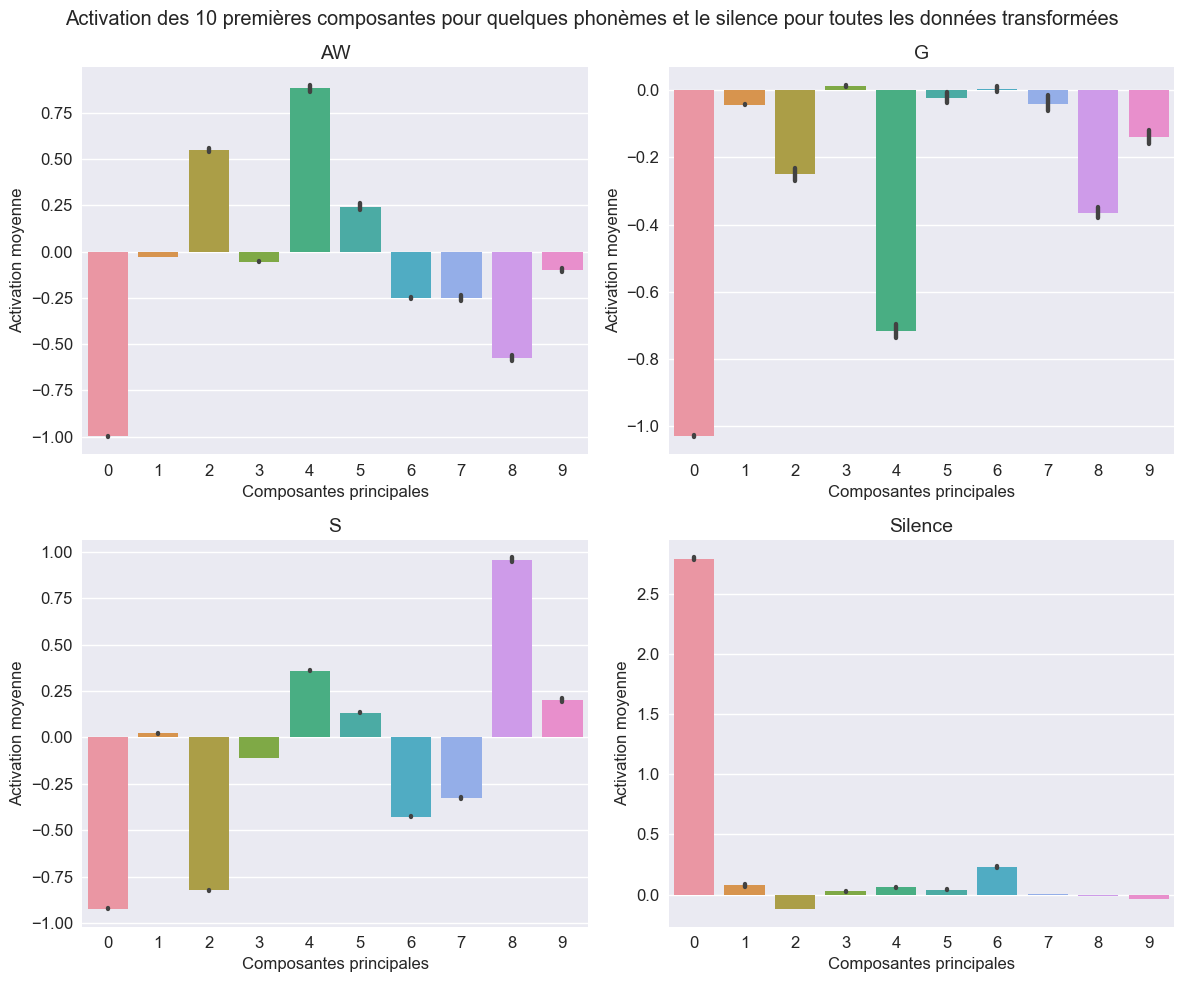

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
phoneme_indexes = np.nonzero(full_df.loc['AW'])
pc_activation = transformed_data[phoneme_indexes[0]]
sns.barplot(pc_activation, ax=ax1)
ax1.set(title='AW', xlabel='Composantes principales', ylabel='Activation moyenne')

phoneme_indexes = np.nonzero(full_df.loc['G'])
pc_activation = transformed_data[phoneme_indexes[0]]
sns.barplot(pc_activation, ax=ax2)
ax2.set(title='G', xlabel='Composantes principales', ylabel='Activation moyenne')

phoneme_indexes = np.nonzero(full_df.loc['S'])
pc_activation = transformed_data[phoneme_indexes[0]]
sns.barplot(pc_activation, ax=ax3)
ax3.set(title='S', xlabel='Composantes principales', ylabel='Activation moyenne')

phoneme_indexes = np.nonzero(full_df.loc['sp'])
pc_activation = transformed_data[phoneme_indexes[0]]
sns.barplot(pc_activation, ax=ax4)
ax4.set(title='Silence', xlabel='Composantes principales', ylabel='Activation moyenne')

fig.suptitle('Activation des 10 premières composantes pour quelques phonèmes et le silence pour toutes les données transformées')
plt.tight_layout()

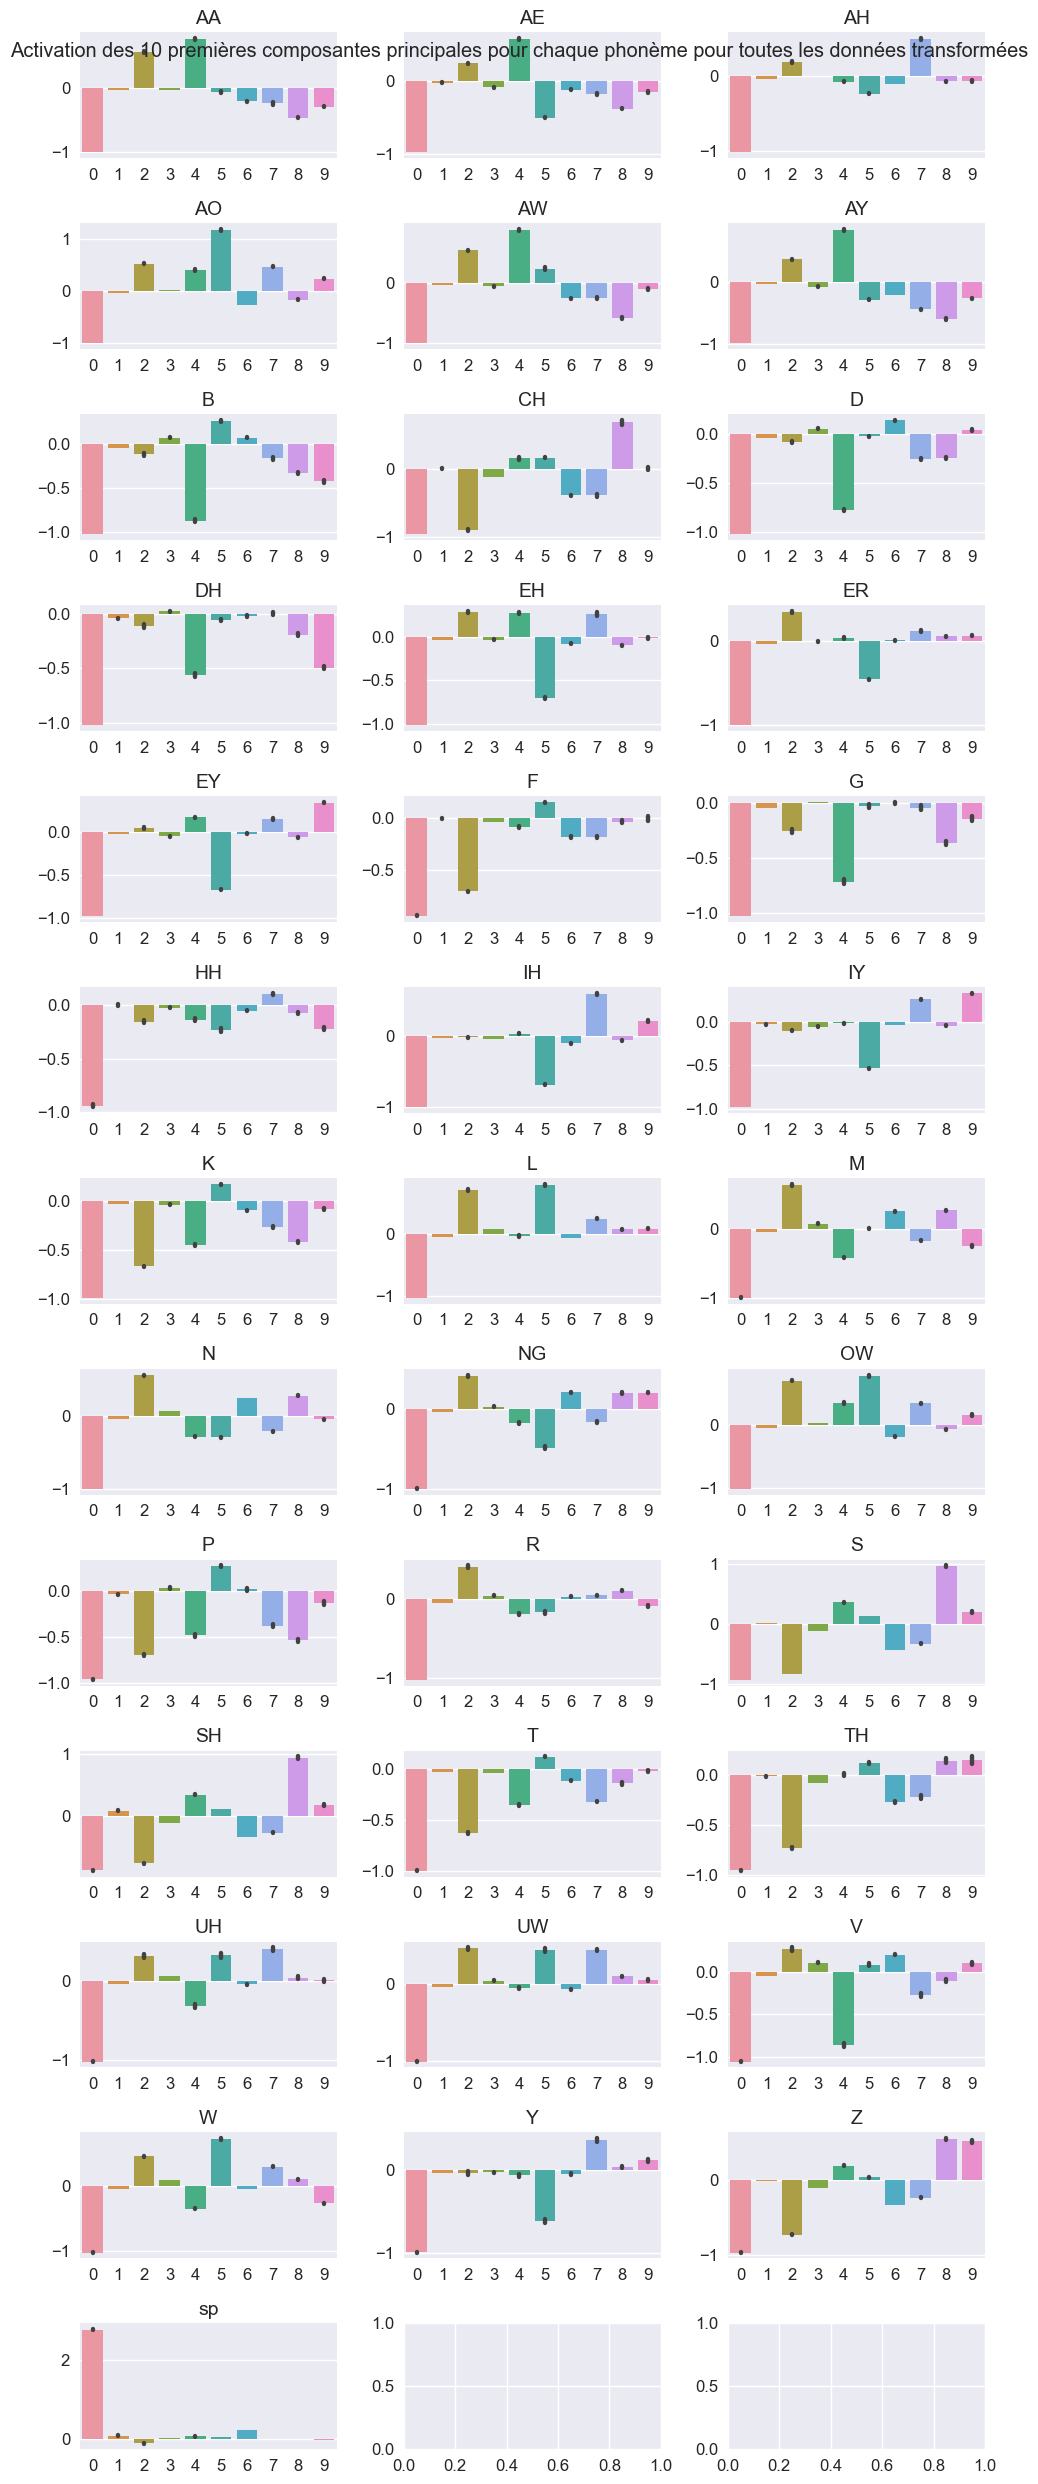

In [17]:
fig, axes=plt.subplots(13, 3, figsize=(10, 25))
axes=np.ravel(axes)
for i, (phoneme, ax) in enumerate(zip(full_df.index, axes), 1):
    phoneme_indexes = np.nonzero(full_df.loc[phoneme])
    pc_activation = transformed_data[phoneme_indexes[0]]
    sns.barplot(pc_activation, ax=ax)
    ax.set_title(phoneme)
    #ax.set_xticks(range(0, 50, 10))
    #plt.ylabel([])
#fig.suptitle('Distribution des variables continues')
# plt.xticks([], [])
# plt.yticks([], [])
plt.tight_layout()
fig.suptitle('Activation des 10 premières composantes principales pour chaque phonème pour toutes les données transformées')
plt.show()

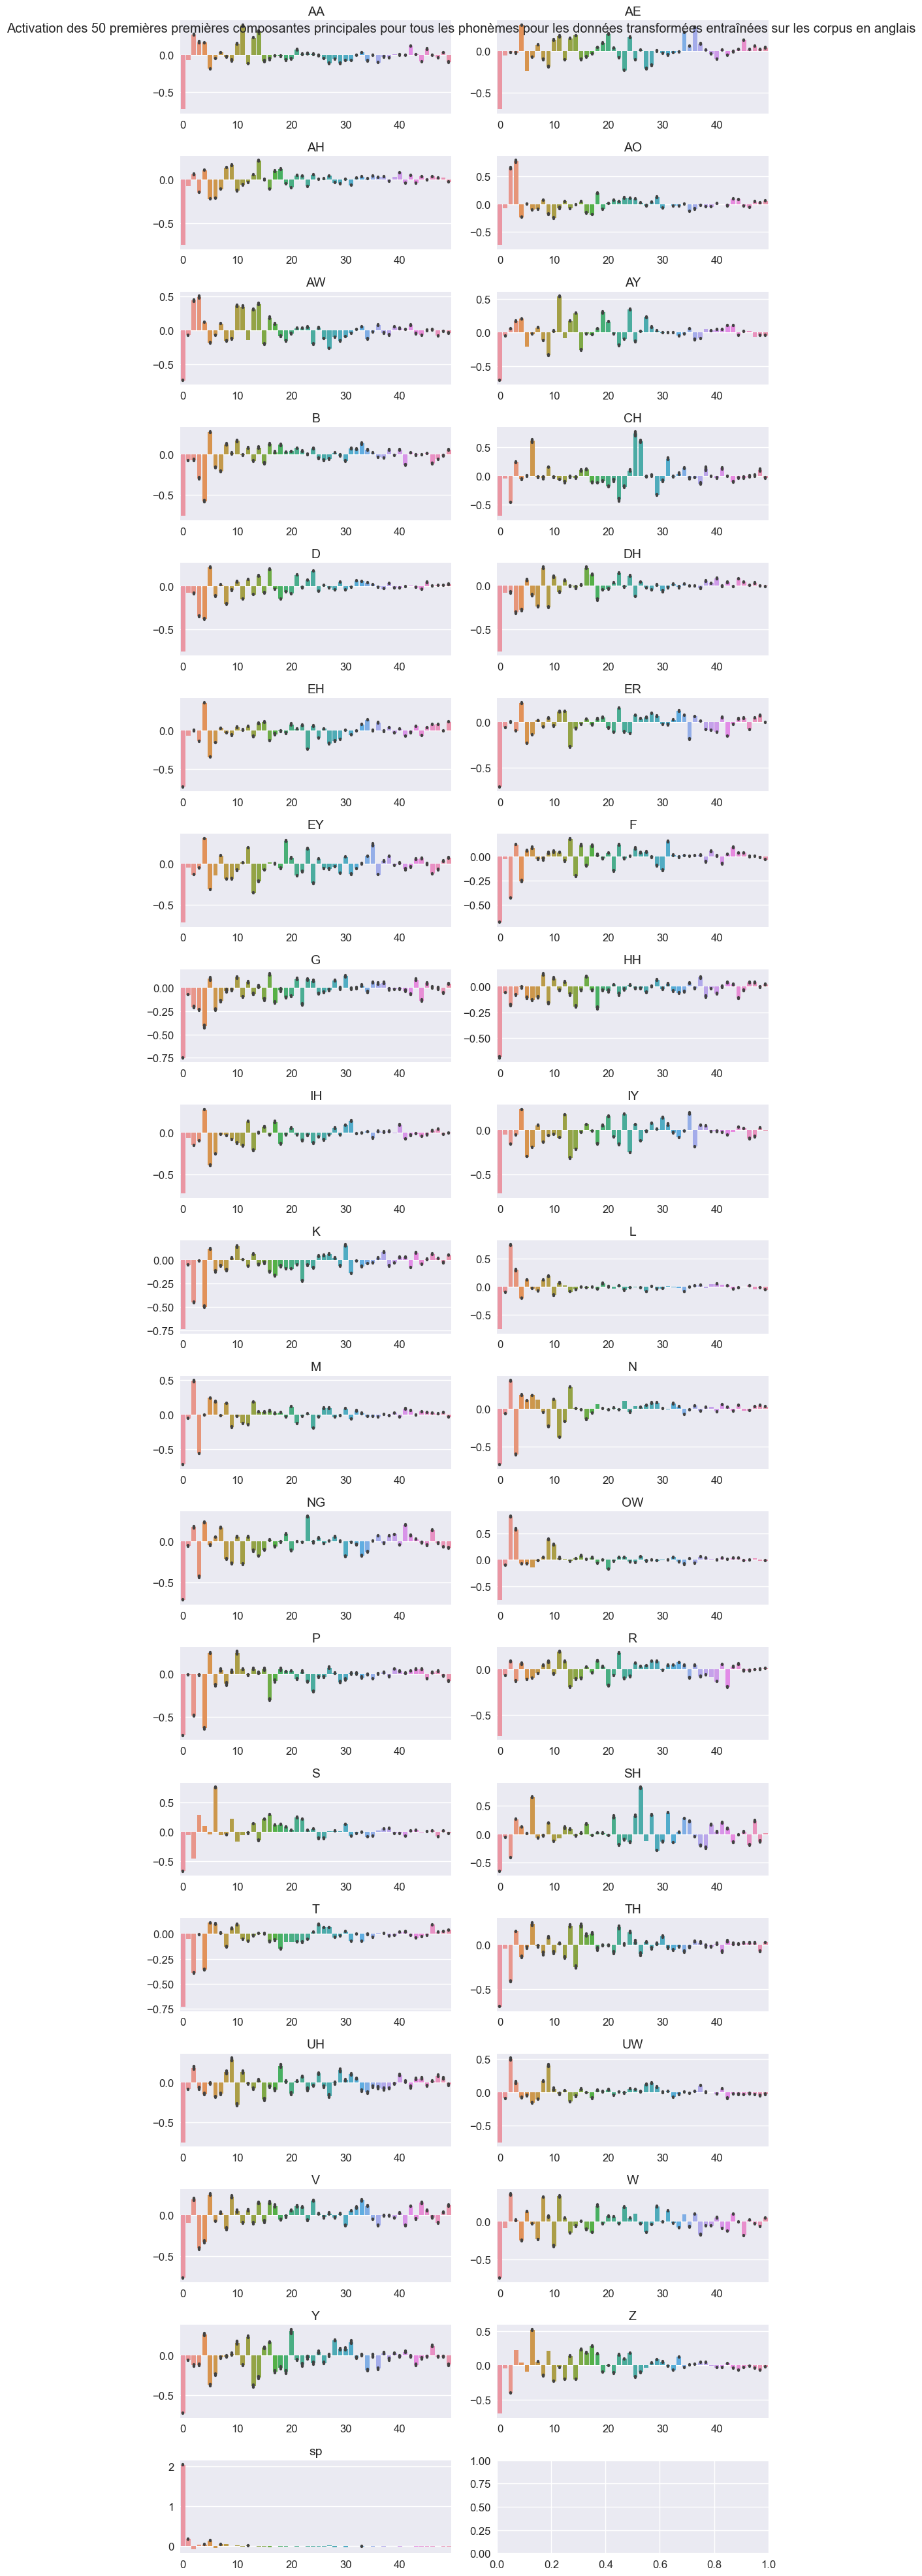

In [28]:
fig, axes=plt.subplots(19, 2, figsize=(10, 40))
axes=np.ravel(axes)
for i, (phoneme, ax) in enumerate(zip(full_df.index, axes), 1):
    phoneme_indexes = np.nonzero(full_df.loc[phoneme])
    pc_activation = transformed_data_en[phoneme_indexes[0], :50]
    sns.barplot(pc_activation, ax=ax)
    ax.set_title(phoneme)
    ax.set_xticks(range(0, 50, 10))
    #plt.ylabel([])
#fig.suptitle('Distribution des variables continues')
# plt.xticks([], [])
# plt.yticks([], [])
fig.suptitle('Activation des 50 premières premières composantes principales pour tous les phonèmes pour les données transformées entraînées sur les corpus en anglais')
plt.tight_layout()
plt.show()

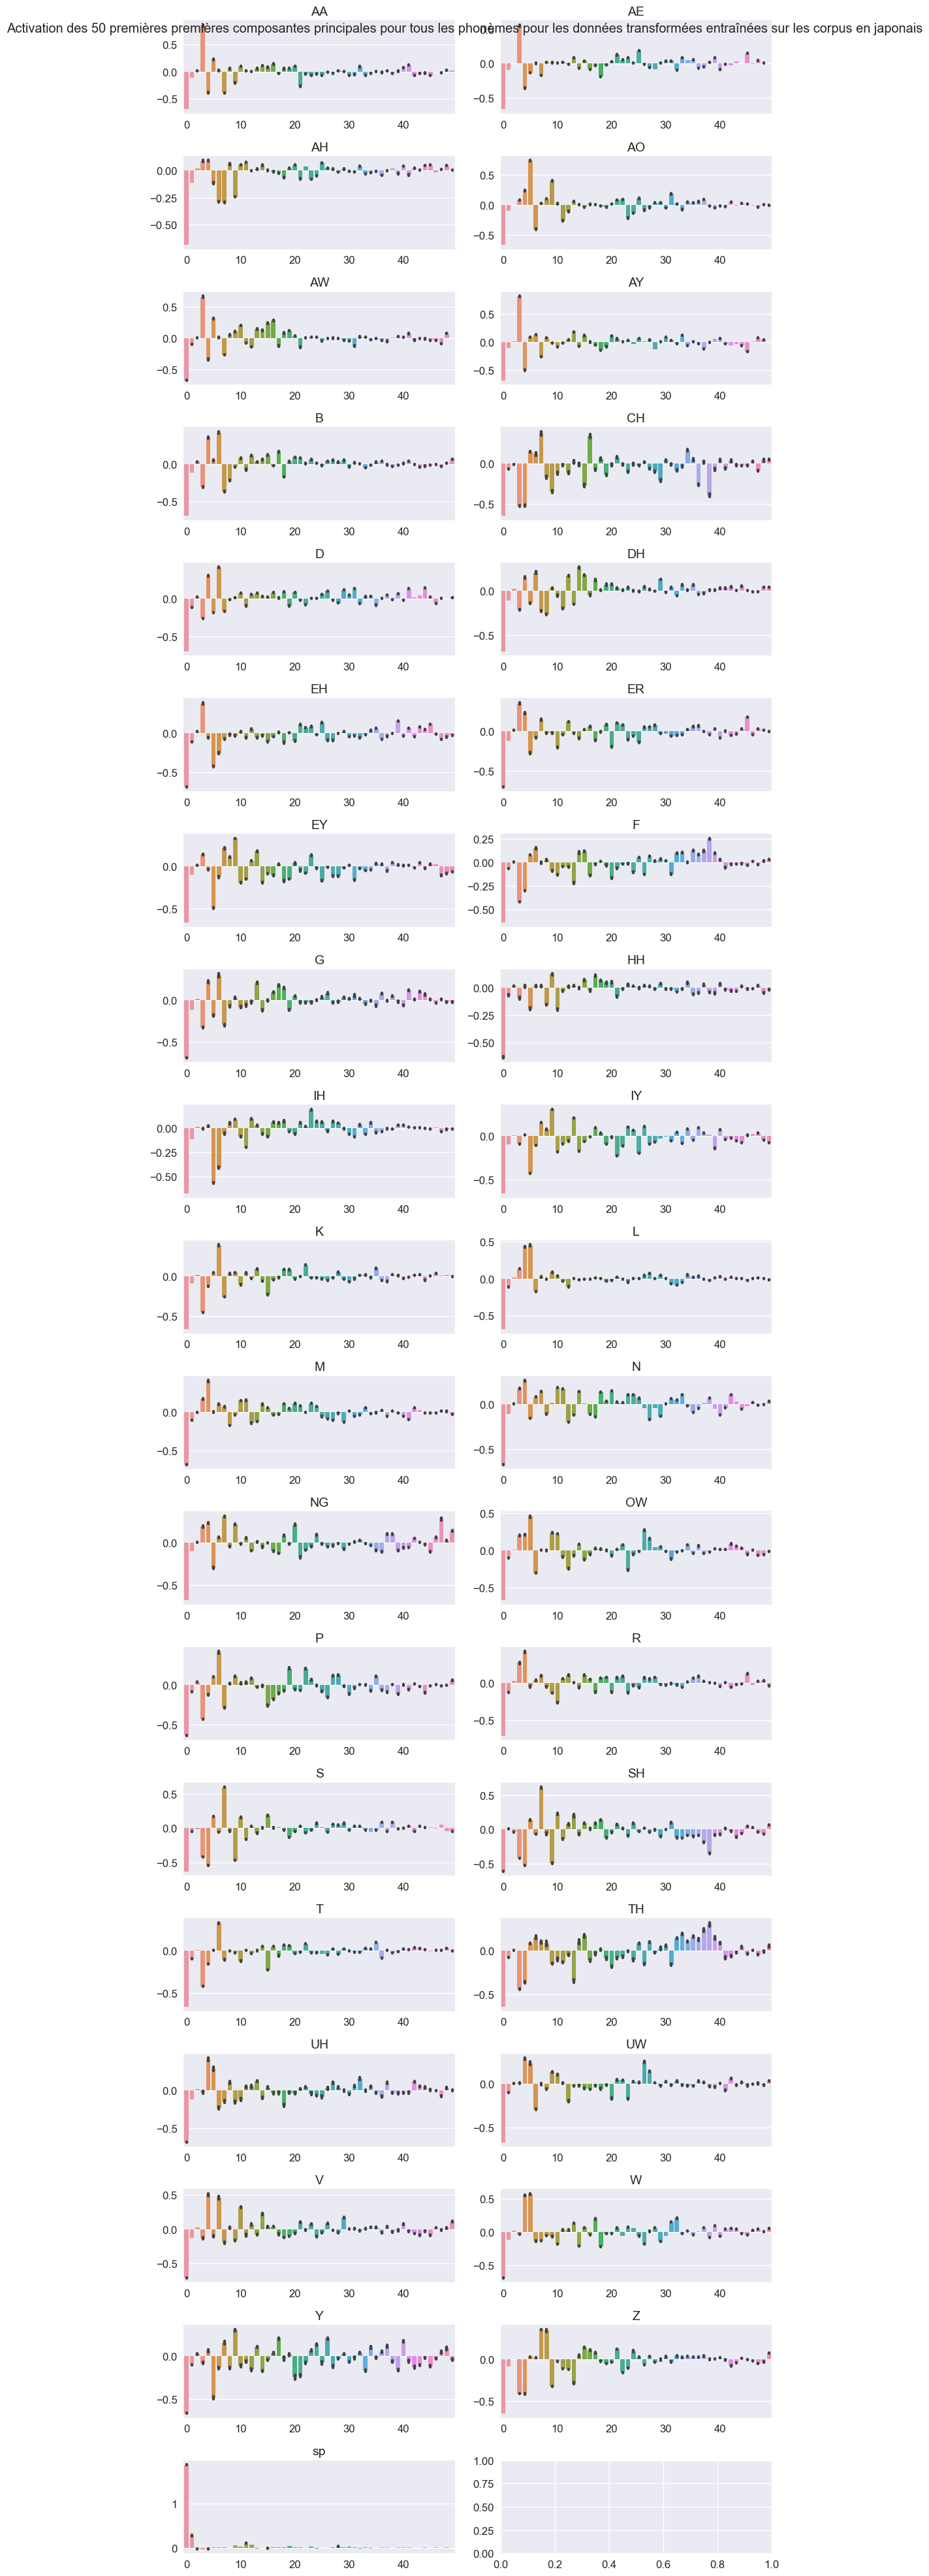

In [21]:
fig, axes=plt.subplots(19, 2, figsize=(10, 40))
axes=np.ravel(axes)
for i, (phoneme, ax) in enumerate(zip(full_df.index, axes), 1):
    phoneme_indexes = np.nonzero(full_df.loc[phoneme])
    pc_activation = transformed_data_jp[phoneme_indexes[0], :50]
    sns.barplot(pc_activation, ax=ax)
    ax.set_title(phoneme)
    ax.set_xticks(range(0, 50, 10))
    #plt.ylabel([])
#fig.suptitle('Distribution des variables continues')
# plt.xticks([], [])
# plt.yticks([], [])
fig.suptitle('Activation des 50 premières premières composantes principales pour tous les phonèmes pour les données transformées entraînées sur les corpus en japonais')
plt.tight_layout()
plt.show()

In [29]:
L_indexes = np.nonzero(full_df.loc['L'])
R_indexes = np.nonzero(full_df.loc['R'])


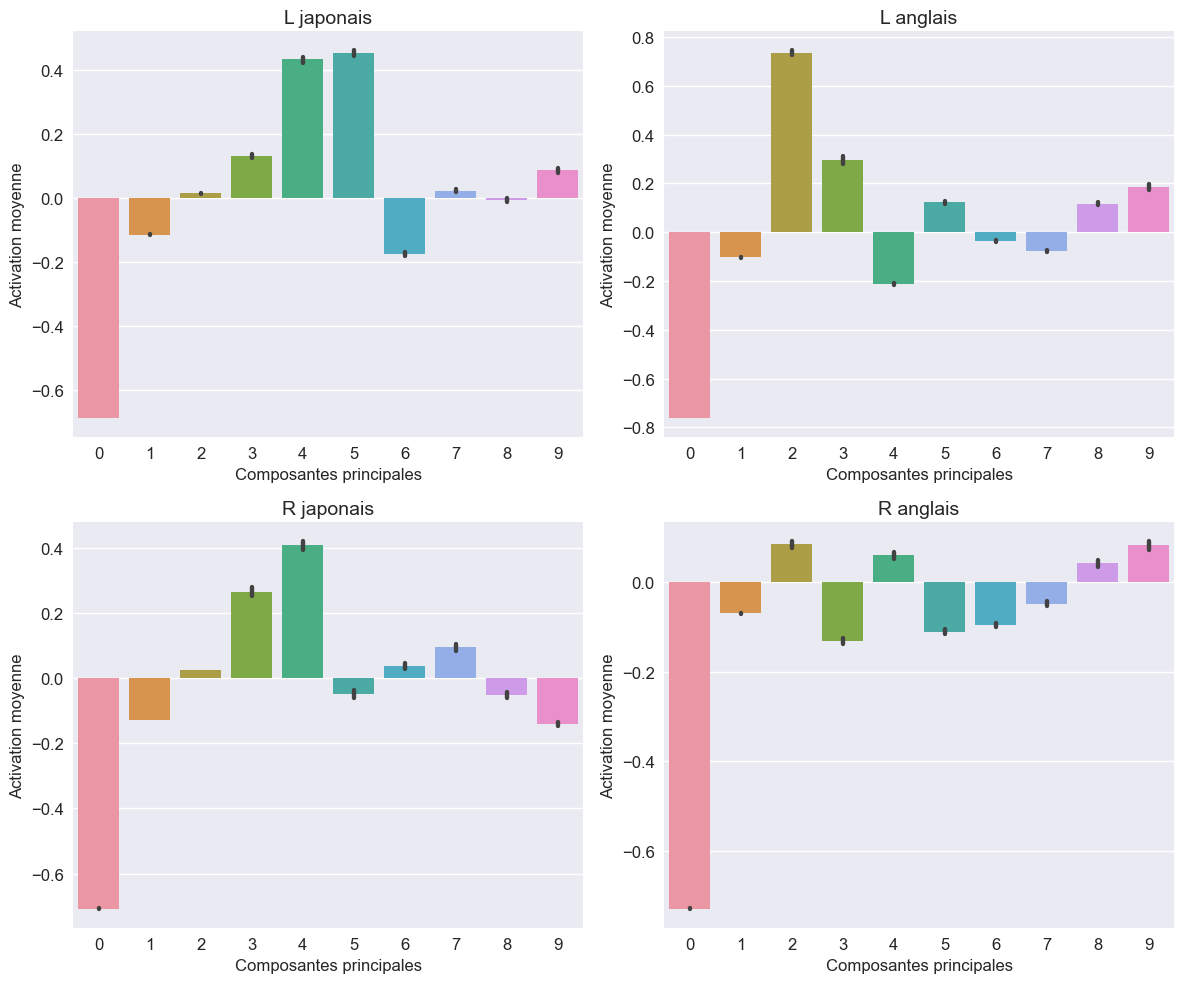

In [30]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
sns.barplot(transformed_data_jp[L_indexes[0], :10], ax=ax1)
sns.barplot(transformed_data_en[L_indexes[0], :10], ax=ax2)
sns.barplot(transformed_data_jp[R_indexes[0], :10], ax=ax3)
sns.barplot(transformed_data_en[R_indexes[0], :10], ax=ax4)
ax1.set(title ="L japonais", xlabel='Composantes principales', ylabel='Activation moyenne')
ax2.set(title="L anglais",  xlabel='Composantes principales', ylabel='Activation moyenne')
ax3.set(title="R japonais",  xlabel='Composantes principales', ylabel='Activation moyenne')
ax4.set(title="R anglais",  xlabel='Composantes principales', ylabel='Activation moyenne')
plt.tight_layout()